# Необхідні бібліотеки та функції

In [1]:
# import libraries

from IPython.display import clear_output, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar import svar_model
from statsmodels.tools.eval_measures import rmse, rmspe, meanabs
from scipy.stats import shapiro
from scipy.stats import ttest_1samp

import plotly.graph_objects as go

In [37]:
# useful functions

def test_stationarity(data):
    for factor in data.columns:
        adf_test = adfuller(data[[factor]]) #use augmented Dicky-Fuller test
        print(f'{factor}: pvalue = {adf_test[1]}')
        
def plot_series(data):
    for factor in data.columns:
        plt.figure(figsize=(15, 5))
        plt.plot(data[[factor]])
        plt.title(factor)
        plt.show() 
        
def plot_inflation_predictions(first_point):    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    preds = [first_point]
    preds_upper2stds = [first_point]
    preds_lower2stds = [first_point]
    
    preds.extend(model.mean_best_inflation_predicts)
    preds_upper2stds.extend(model.mean_best_inflation_predicts+2*model.std_best_inflation_predicts)
    preds_lower2stds.extend(model.mean_best_inflation_predicts-2*model.std_best_inflation_predicts)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=months[:6],
                             y=data['2022':]['Annual Inflation Rate'],
                             line=dict(width=4, color='blue'),
                             mode='lines',
                             name='Inflation rate'))

    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds_upper2stds,
                             line=dict(width=4, dash='dot', color='lightgreen'),
                             mode='lines',
                             name='Upper 2STDs'))

    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds_lower2stds,
                             line=dict(width=4, dash='dot', color='lightgreen'),
                             mode='lines',
                             fill='tonexty',
                             name='Lower 2STDs'))
    
    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds,
                             line=dict(width=4, dash='dash', color='blue'),
                             mode='lines',
                             name='Inflation rate forecast'))
    
    fig.update_layout(title='Прогноз темпу інфляції на кінець 2022 року', yaxis_title='Темп інфляції')
    
    fig.show()

def test_normality(residuals, variables):
    for idx, factor in enumerate(variables):
        pvalue = shapiro(residuals[:, idx])[1]
        if pvalue > 0.05:
            print(f'{factor}: residuals are normally distributed, p-value = {pvalue}')
        else:
            print(f'{factor}: residuals are not normally distributed, p-value = {pvalue}')
            
def test_resid_mean(residuals, variables):
    for idx, factor in enumerate(variables):
        pvalue = ttest_1samp(residuals[:, idx], 0)[1]
        if pvalue > 0.05:
            print(f'{factor} residuals mean is 0, p-value = {pvalue}')
        else:
            print(f'{factor}: residuals mean is not, p-value = {pvalue}')

# Завантаження та підготовка даних

In [3]:
macrodata = pd.read_csv('macrodata.csv', delimiter=';', decimal=',', encoding='windows-1251')

In [4]:
macrodata.index = pd.date_range('2013-01', '2022-10', freq='M')
macrodata.columns

Index(['Date', 'CPI', 'Annual Inflation Rate', 'UK CPI', 'US CPI', 'EU CPI',
       'Inf Expect (Households)', 'Interest Rate', 'REER', 'NEER',
       'Gross Foreign Reserves', 'Net Foreign Reserves', 'Interv',
       'Domestic Gov Bonds'],
      dtype='object')

Дані містять наступні фактори:
> CPI - Індекс споживчих цін у постійних цінах грудня 2010 року.

> Annual Inflation Rate - річна споживча інфляція (темп інфляції)

> UK CPI, US CPI, EU CPI - темпи інфляції у Великобританії, США та ЄС

> Inf Expect (Households) - інфляційні очікування домогосподарств

> Interest Rate - облікова ставка НБУ

> REER, NEER - реальний на номінальний ефективні валютні курси

> Gross Foreign Reserves - валові міжнародні резерви

> Net Foreign Reserves - чисті міжнародні резерви

> Interv - сальдо валютних інтервенцій

> Domestic Gov Bonds - середньозважена дохідність від ОВДП


In [5]:
data = macrodata.dropna().copy()
data = data.drop(['CPI', 'Date'], axis=1)
data

,Annual Inflation Rate,UK CPI,US CPI,EU CPI,Inf Expect (Households),Interest Rate,REER,NEER,Gross Foreign Reserves,Net Foreign Reserves,Interv,Domestic Gov Bonds
2016-01-31,40.2,0.3,1.4,0.3,21.5,22.0,1.03,1.03,13.29999,1.33583,-0.074300,6.25
2016-02-29,32.7,0.3,1.0,-0.1,20.5,22.0,0.94,0.94,13.44159,1.40398,-0.158800,19.80
2016-03-31,20.9,0.5,0.9,0.0,17.1,22.0,0.92,0.92,13.48950,1.55101,-0.002097,19.42
2016-04-30,9.8,0.3,1.1,-0.2,17.3,19.0,0.95,0.92,12.72151,1.03251,0.675817,18.37
2016-05-31,7.5,0.3,1.0,-0.1,15.5,18.0,0.96,0.93,13.24095,2.32642,0.332693,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,10.7,6.2,7.9,6.2,13.0,10.0,1.26,0.95,29.08698,18.97315,-0.307800,11.62
2022-03-31,13.7,7.0,8.5,7.8,7.6,10.0,1.30,0.95,27.55286,17.55448,-1.776200,10.96
2022-04-30,16.4,9.0,8.3,8.1,8.1,10.0,1.33,0.96,28.10745,17.56991,-2.203310,10.92
2022-05-31,18.0,9.1,8.6,8.8,13.1,10.0,1.39,0.98,26.94507,16.77922,-3.354210,10.75


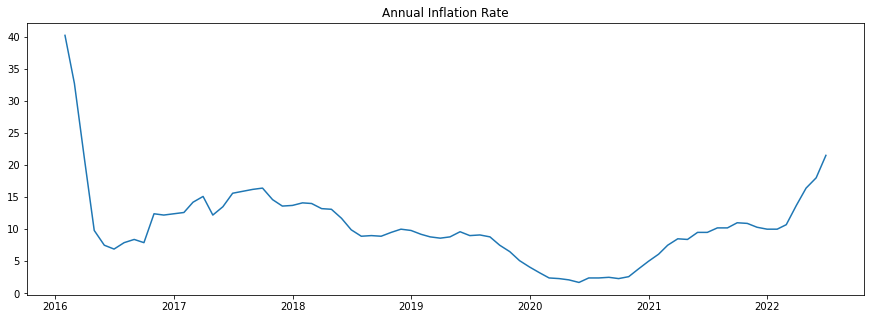

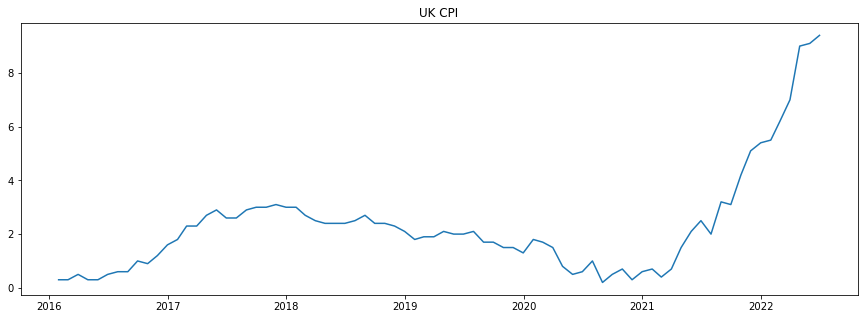

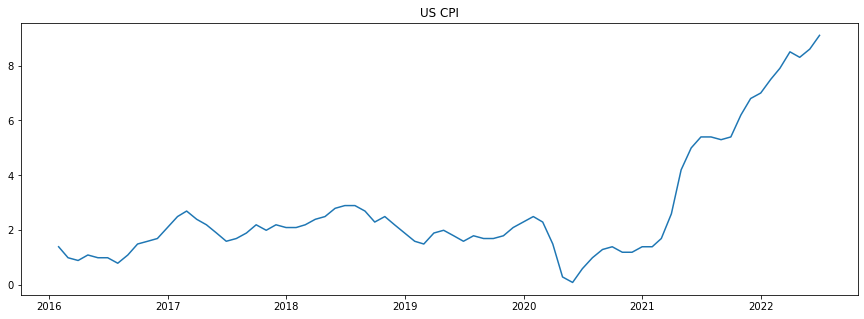

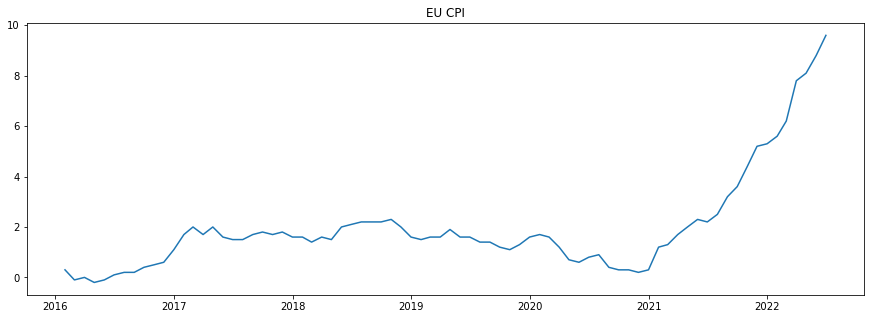

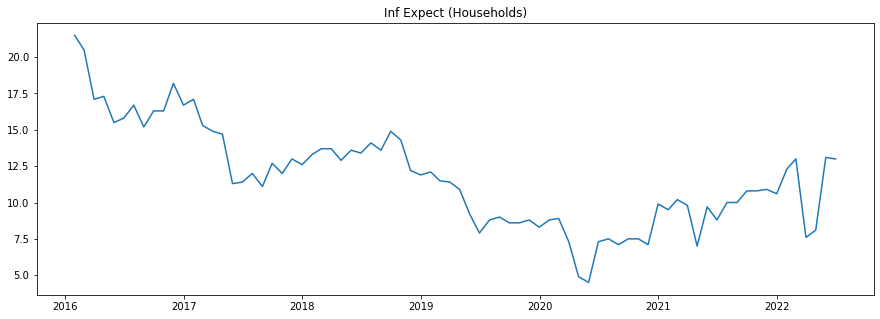

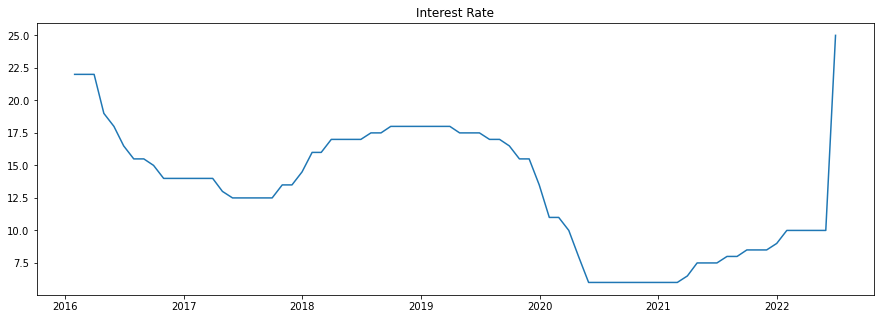

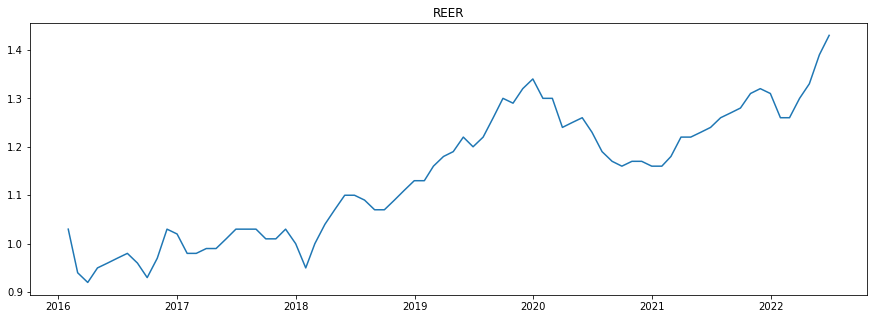

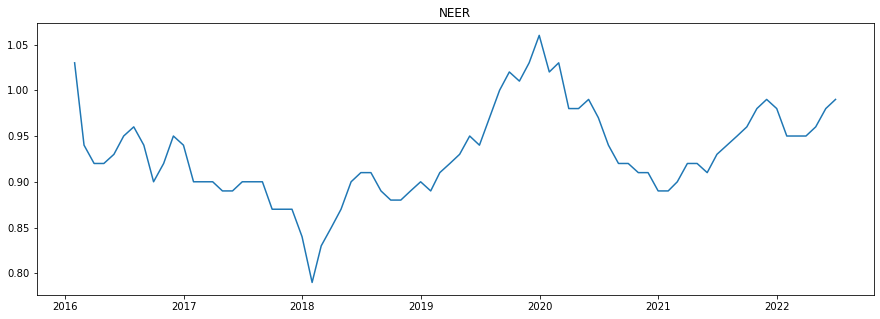

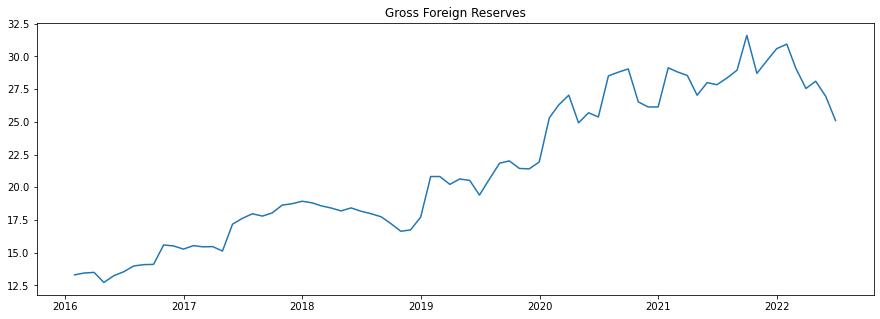

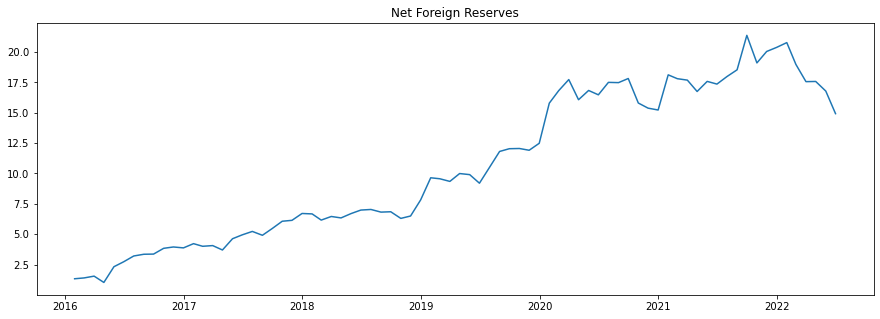

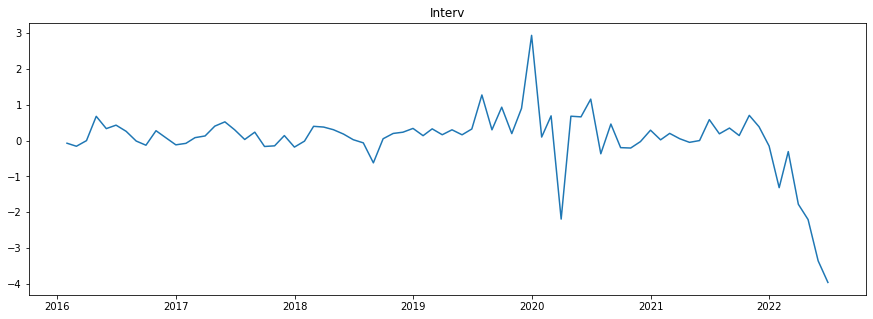

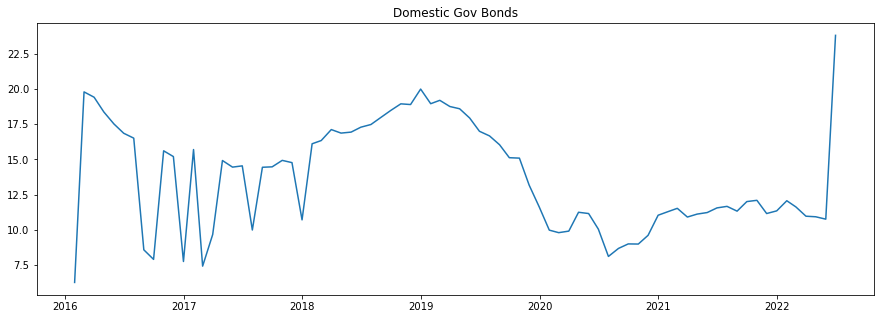

In [6]:
# plotting data

plot_series(data)

In [7]:
# stationarity testing
test_stationarity(data)

Annual Inflation Rate: pvalue = 0.8122072312103654
UK CPI: pvalue = 0.7589486283651402
US CPI: pvalue = 0.999019066643684
EU CPI: pvalue = 1.0
Inf Expect (Households): pvalue = 0.209746588103577
Interest Rate: pvalue = 0.6134987236989533
REER: pvalue = 0.8532141225046872
NEER: pvalue = 0.3246743311061132
Gross Foreign Reserves: pvalue = 0.7613291733853021
Net Foreign Reserves: pvalue = 0.7973080675114169
Interv: pvalue = 0.9978740973141208
Domestic Gov Bonds: pvalue = 0.45140375644430225


Ряди нестаціонарні

# Bagging над VECM

Нестаціонарність рядів змушує застосувати векторну модель корекції помилок (VECM). Водночас ми упираємося в фундаментальні проблеми:

1) Кількість факторів, які можна включити в модель, сильно обмежена, оскільки довжина ряду замала (див. [Прокляття розмірності](https://uk.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D1%82%D1%8F_%D1%80%D0%BE%D0%B7%D0%BC%D1%96%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%96)).

2) Попередні дані містять значну кількість нетипових значень (інфляційний шок 2014-2015 років), а тому можуть нашкодити якості моделі.

3) Складно визначити оптимальні гіперпараметри моделі (максимальний лаг, наявність тренду та/або константи в моделі і т.д.)

Необхідно обрати такий підхід, який дозволить врахувати вплив усіх обраних факторів, але при цьому залишить модель простою. Скористаємося підходом, який має назву bagging, та модифікуємо його для роботи з часовими рядами. Ідея наступна:
1) На кожній ітерації обираємо $k$ випадкових факторів.

2) Визначаємо максимальний лаг $p$.

3) У циклі для обраних факторів та лагу з проміжку від 1 до $p$ визначаємо ранг коінтеграції рядів ($r$). Якщо $r=0$, то не будуємо модель. Якщо $r \neq 0$, то робимо висновок, що ряди коінтегровані.

4) Будуємо VEC-модель з поточним лагом та визначеним рангом коінтеграції.

5) Зберігаємо результати прогнозу для інфляції та облікової ставки на 6 місяців (з липня по грудень).

6) Порівнюємо прогнози моделі з тестовими (інфляція та ставка за липень та серпень).

7) Якщо прогнози відповідають заданим критеріям точності, то зберігаємо результати прогнозу моделі як найкращі.

8) Після останньої ітерації агрегуємо прогнози багатьох моделей, окремо - прогнози лише найкращих. Для кожного місячного прогнозу визначаємо середнє, стандартне відхилення, а також верхню та нижню межу прогнозу (на рівні 2 стандартних відхилень від середнього)

Отже, замість того, щоб будувати одну сильну модель, ми будуємо велику кількість порівняно слабких, тобто застосовуємо <i>ансамблеве навчання</i>

In [10]:
# build our model
class BaggingVECM():
    
    """
    BaggingVECM class that predicts annual inflation rate and interest rate.
    Methods:
    > fit_model() -- fits BaggingVECM, makes predictions and chooses the best models
    > predict_info() -- aggregates all models, including the best, prints useful information about predictions
    """
    
    
    def __init__(self):
        pass
        
        
    def fit_model(self, data: pd.DataFrame, start_date: str,
            end_date: str, test_data: list,
            predict_periods: int,  target_factors: list=['Annual Inflation Rate', 'Interest Rate'],
            random_factors_num: int=3, maxlag: int=6, num_iter: int=500, acc: float = 1.0) -> None:
        
        """Fits BaggingVECM, makes predictions and chooses the best models. 
            data: pd.DataFrame -- data;
            start_date: str -- the first date of series, format: "YYYY-MM-DD", "MM" and "DD" are optional;
            end_date: str -- the last date of series, format: see start_date;
            test_data: list -- test data to choose the best models;
            predict_periods: int -- number of periods to predict;
            target_factors: list -- list of factors to predict;
            random_factors_num: int -- number of factors to include in each VEC model;
            maxlag: int -- the largest lag to include in the model;
            num_iter: int -- number of iterations;
            acc: float -- criterion to choose the best models."""
        
        all_factors = data.columns.drop(target_factors)
        data = data[start_date:end_date]
        
        self.best_inflation_predicts = []
        self.best_models = []
        
        for iteration in range(num_iter):
            # select random factor(s)
            factors = target_factors.copy()
            chosen_factors = np.random.choice(all_factors, size=random_factors_num, replace=False)
            factors.extend(chosen_factors)

            print(f'Iteration #{iteration}')
            clear_output(wait=True)

            for lag in range(1, maxlag+1):
                # cointegration test
                coint_rank_test = vecm.select_coint_rank(data[factors], det_order=0, k_ar_diff=lag)
                coint_rank = coint_rank_test.rank
                if coint_rank == 0:
                    continue

                # build a model
                vecmodel = vecm.VECM(data[factors], k_ar_diff=lag, coint_rank=coint_rank, deterministic='ci')
                vecresult = vecmodel.fit()

                # predict on test data
                test_inflation_pred = vecresult.predict(len(test_data))[:, 0]
                
                # choose the best predicts
                inflation_abs_error = np.array(np.abs(test_data - test_inflation_pred))
                if (all(inflation_abs_error <= acc)):
                    self.best_inflation_predicts.append(vecresult.predict(predict_periods)[:, 0])
                    self.best_models.append(vecresult)

        self.best_inflation_predicts = np.array(self.best_inflation_predicts)
        self.best_models = np.array(self.best_models)

        print('Done!', f'number of selected models: {len(self.best_inflation_predicts)}')


    def predict_info(self) -> None:
        
        """Aggregates all models, including the best, prints useful information about predictions"""

        self.mean_best_inflation_predicts = np.round(np.mean(self.best_inflation_predicts, axis=0), 2)
        self.std_best_inflation_predicts = np.round(np.std(self.best_inflation_predicts, axis=0), 2)
        print('***Best inflation predicts:')
        print(f'Mean: {self.mean_best_inflation_predicts}')
        print(f'STD: {self.std_best_inflation_predicts}')
        print(f'Upper 2STDs: {self.mean_best_inflation_predicts + 2*self.std_best_inflation_predicts}')
        print(f'Lower 2STDs: {self.mean_best_inflation_predicts - 2*self.std_best_inflation_predicts} \n')
     
        
        

#### Модель із врахуванням підвищення облікової ставки у червні 2022 року до 25%

In [17]:
# include intrate = 25.0%

model = BaggingVECM()
model.fit_model(data=data, start_date='2016', end_date='2022-06', test_data=[22.2, 23.8], predict_periods=6, num_iter=3000, acc=1.5)
model.predict_info()

Done! number of selected models: 1824
***Best inflation predicts:
Mean: [22.1  23.81 24.62 23.63 23.05 22.55]
STD: [0.86 0.84 2.26 3.03 4.69 5.41]
Upper 2STDs: [23.82 25.49 29.14 29.69 32.43 33.37]
Lower 2STDs: [20.38 22.13 20.1  17.57 13.67 11.73] 



In [43]:
plot_inflation_predictions(first_point=21.5)

#### Розгляд сценаріїв за різних рівнів облікової ставки

In [27]:
sim_res = {}
for intrate in range(15, 26):
    data_ir_sim = data.copy()
    data_ir_sim.loc["2022-06-30", "Interest Rate"] = intrate
    print(f'Interest rate = {intrate}')

    model_ir_sim = BaggingVECM()
    model_ir_sim.fit_model(data=data_ir_sim, start_date='2016', end_date='2022-06', test_data=[22.2, 23.8], predict_periods=6, num_iter=1000, acc=5)
    model_ir_sim.predict_info()
    sim_res[intrate] = model_ir_sim.mean_best_inflation_predicts
clear_output()

In [28]:
sim_res

{15: array([22.99, 24.4 , 25.15, 25.49, 26.04, 26.43]),
 16: array([22.87, 24.3 , 25.  , 25.21, 25.64, 25.91]),
 17: array([22.81, 24.3 , 24.95, 25.05, 25.42, 25.62]),
 18: array([22.73, 24.24, 24.82, 24.77, 25.03, 25.11]),
 19: array([22.59, 24.14, 24.67, 24.48, 24.64, 24.69]),
 20: array([22.57, 24.16, 24.69, 24.42, 24.56, 24.56]),
 21: array([22.54, 24.16, 24.57, 24.1 , 24.06, 23.95]),
 22: array([22.47, 24.16, 24.61, 24.07, 24.03, 23.88]),
 23: array([22.49, 24.3 , 24.74, 24.03, 23.89, 23.76]),
 24: array([22.37, 24.13, 24.47, 23.56, 23.32, 23.07]),
 25: array([22.34, 24.27, 24.58, 23.59, 23.35, 23.19])}

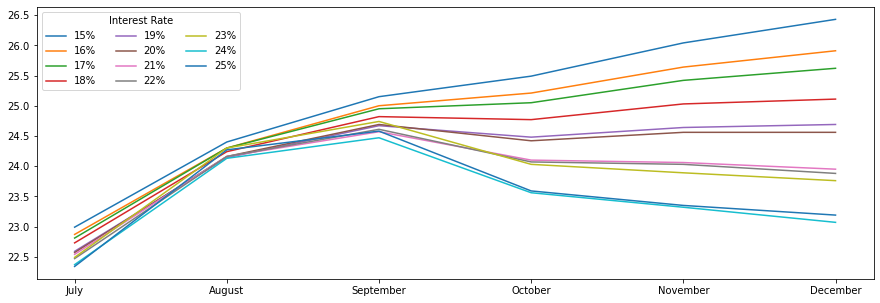

In [29]:
plt.figure(figsize=(15,5))
for idx in sim_res.keys():
    plt.plot(['July', 'August', 'September', 'October', 'November', 'December'], sim_res[idx], label=f'{idx}%')

plt.legend(loc='upper left', ncol=3, title='Interest Rate')
plt.show()

Графік показує, як реагуватиме рівень інфляції впроводовж 2022 року за різних значень облікової ставки. Видно, що зменшення інфляції в кінці року є можливим лише в тому випадку, якщо облікова ставка становитиме 21% та більше. Крім того, за облікової ставки 24% та 25% траєкторії темпів інфляції майже збігаються.

# Структурний аналіз моделі

#### Найкраща наближена модель

Беґґінг на векторними моделями корекції помилок дозволяє робити непоганий прогноз інфляції, проте не дозволяє інтерпретувати та проаналізувати модель. Щоб це було можливим, можна обрати з найкращих моделей ту, прогнози котрої найменше відхиляються від середнього прогнозу.

In [18]:
def choose_best_model(models, predict_period: int=6):
    forecasts = []
    for model_ in models:
        forecasts.append(model_.predict(predict_period)[:, 0])
        
    mean_forecasts = np.mean(forecasts, axis=0)
    deviations = []
    for forecast in forecasts:
        deviation = meanabs(mean_forecasts, forecast)
        deviations.append(deviation)
    
    best_model = models[np.argmin(deviations)]
    return best_model


In [19]:
best_model = choose_best_model(model.best_models)
print(f'Factors of the best model: {best_model.names}')
#best_model.irf().plot(figsize=(20,20))

Factors of the best model: ['Annual Inflation Rate', 'Interest Rate', 'EU CPI', 'Interv', 'REER']


In [20]:
print(f'Forecasts of the best model: {np.round(best_model.predict(6)[:, 0], 2)}')
print(f'Mean forecasts: {model.mean_best_inflation_predicts}')

Forecasts of the best model: [22.48 23.77 25.45 24.17 23.09 23.12]
Mean forecasts: [22.1  23.81 24.62 23.63 23.05 22.55]


#### Прогнози наближеної моделі

In [45]:
best_model.predict(6, 0.05)

(array([[22.47510405, 32.19804375, 12.20471014,  0.64576941,  1.35282897],
        [23.77412834, 26.78472753, 13.30164299,  3.52373444,  1.41339047],
        [25.45168209, 33.18053897, 14.37443981,  0.86901793,  1.69160201],
        [24.17313141, 44.59251245, 15.65735786, -6.57146193,  1.80396542],
        [23.08873024, 44.63309527, 16.57518206, -3.98863943,  1.9222803 ],
        [23.12443952, 47.16856045, 17.00288631,  1.5188731 ,  2.13949253]]),
 array([[21.15715787, 30.57244448, 11.75935647, -0.16031693,  1.32301102],
        [21.72526792, 24.6428865 , 12.52066982,  2.57538665,  1.36638688],
        [22.77705494, 30.61929708, 13.30639365, -0.20181118,  1.63479825],
        [21.03810542, 41.58844231, 14.34567173, -7.93592989,  1.73494546],
        [19.5005588 , 41.0846844 , 14.91970334, -5.67388041,  1.84256758],
        [19.00410055, 43.28697676, 14.97002507, -0.24600514,  2.0469697 ]]),
 array([[23.79305022, 33.82364301, 12.6500638 ,  1.45185574,  1.38264691],
        [25.82298876,

#### Тест Ґренджера на причинність

Проаналізуємо дану модель, провівши тест Ґренджера на причинність та дослідивши функції імпульсного відгуку, щоб дізнатися реакцію факторів моделі на шоки відсоткової ставки.

In [21]:
print(best_model.test_granger_causality('Annual Inflation Rate', 'Interest Rate').summary())
print(best_model.test_granger_causality('Annual Inflation Rate', 'Interv').summary())

Granger causality F-test. H_0: Interest Rate does not Granger-cause Annual Inflation Rate. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.353          2.073   0.230 (7, 145)
----------------------------------------------
Granger causality F-test. H_0: Interv does not Granger-cause Annual Inflation Rate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.134          2.073   0.044 (7, 145)
----------------------------------------------


Зміни відсоткової ставки не спричиняють (за Ґренджером) короткострокових змін темпу інфляції, але зміни сальдо валютних інтервенцій - спричиняють. Таким чином, облікова ставка в поточних умовах не є основним інструментом монетарної політики.

#### Функції імпульсного відгуку та розклад дисперсії похибки прогнозу

Функції імпульсного відгку дозволяють дослідити, як шоки в одній змінній (імпульсі) впливають на іншу змінну (відгук).

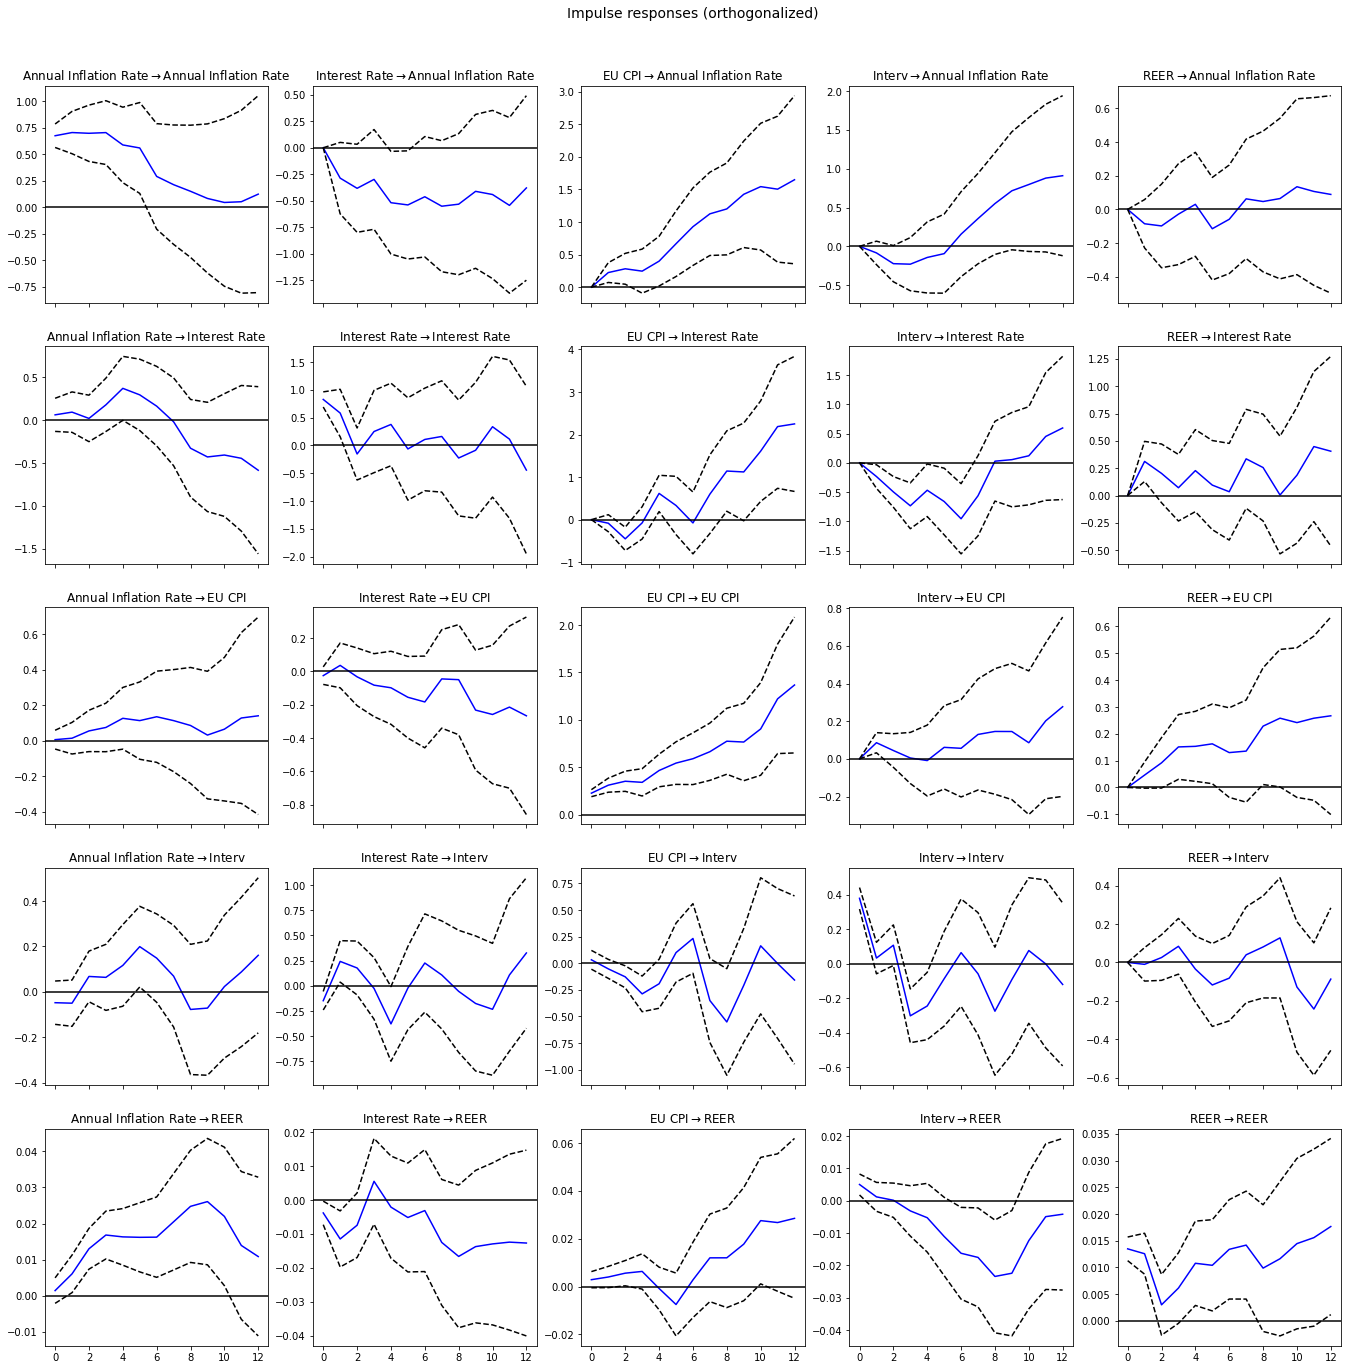

In [22]:
irf = best_model.irf(periods=12)
irf.plot(figsize=(20, 20), orth=True)
plt.show()

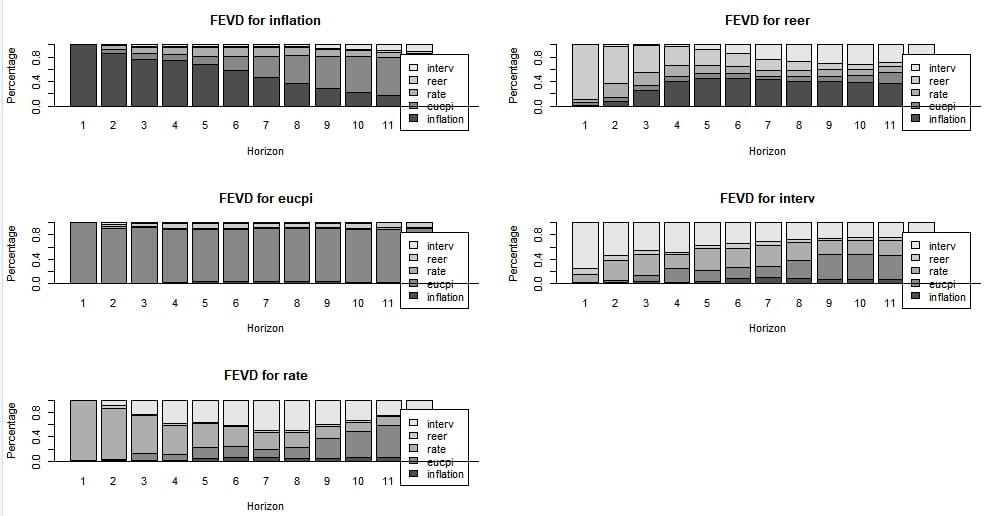

In [44]:
fevd = Image(filename='fevd.jpg')
fevd

Наша невпевненість в майбутніх прогнозах щодо інфляції суттєво залежить від зовнішнього середовища.

# Інші характеристики моделі

#### Перевірка залишків на відповідність нормальному розподілу із $\mu = 0$

In [23]:
#normality testing

test_normality(residuals=best_model.resid, variables=best_model.names)

Annual Inflation Rate: residuals are normally distributed, p-value = 0.23512403666973114
Interest Rate: residuals are normally distributed, p-value = 0.17326410114765167
EU CPI: residuals are normally distributed, p-value = 0.35386720299720764
Interv: residuals are not normally distributed, p-value = 0.004845696967095137
REER: residuals are normally distributed, p-value = 0.1365266740322113


In [24]:
test_resid_mean(residuals=best_model.resid, variables=best_model.names)

Annual Inflation Rate residuals mean is 0, p-value = 0.5804085848122111
Interest Rate residuals mean is 0, p-value = 0.6154610433196595
EU CPI residuals mean is 0, p-value = 0.4067369927677573
Interv residuals mean is 0, p-value = 0.7274602481670525
REER residuals mean is 0, p-value = 0.5216851306610542
